# Projet 9 : Prédisez la demande en électricité 

## Scénario

**Prérequis**

Pour effectuer ce projet, vous devrez maîtriser la manipulation de données en Python ou R, connaître la modélisation de type régression linéaire, ainsi que les différentes modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)
<br><br>
**Mise en situation**

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !


## Les données

Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette [page](https://www.rte-france.com/eco2mix/telecharger-les-indicateurs).

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : [https://cegibat.grdf.fr/simulateur/calcul-dju](https://cegibat.grdf.fr/simulateur/calcul-dju)

## Vos missions

Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

<ol><li>Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
<li>Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
<li>Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.</li></ol>

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

## Environnement

In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels as sm
import pingouin as pg
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from scipy.stats import shapiro

In [2]:
path = '../P9/P9_00_datasets/'

## Mission 1

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire

### Données en énergie - RTE

In [3]:
df = pd.read_csv(path + 'eCO2mix_RTE_energie_M.csv', sep=';', parse_dates=[0], index_col=0)
df.head()

,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
Mois,,,,,,,,,,,,,,,,,,,,,
2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,...,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0,NaN
2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,...,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0,NaN
2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,...,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0,NaN
2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,...,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0,NaN
2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,...,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0,NaN


In [4]:
#energy data (consolidated and final): they relate to France and the 12 administrative regions
df = df[df['Territoire'] == 'France'].drop('Unnamed: 22', axis=1)

#brief data description
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 2012-01-01 to 2021-10-01
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Qualité                                   118 non-null    object 
 1   Territoire                                118 non-null    object 
 2   Production totale                         118 non-null    int64  
 3   Production nucléaire                      118 non-null    float64
 4   Production thermique totale               118 non-null    int64  
 5   Production thermique charbon              118 non-null    float64
 6   Production thermique fioul                118 non-null    int64  
 7   Production thermique gaz                  118 non-null    int64  
 8   Production hydraulique                    118 non-null    int64  
 9   Production éolien                         118 non-null    int64  
 10  Production solaire 

📌

[Description des données en énergie](https://assets.rte-france.com/prod/public/2020-07/éCO2mix%20-%20Description%20des%20fichiers%20des%20données%20en%20énergie.pdf)

Production totale et consommation totale en GWh

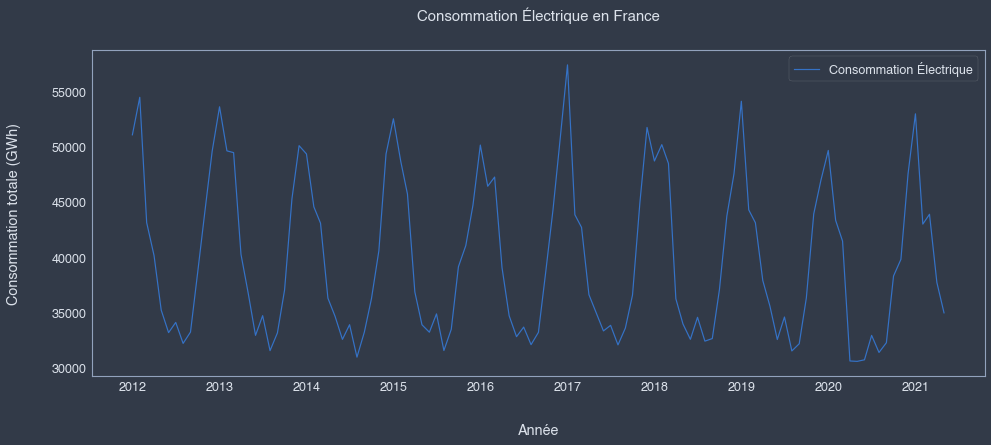

In [48]:
#dataviz
plt.figure(figsize=(16,6))

sns.lineplot(data=df, x='Mois', y='Consommation totale')
plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation Électrique'])

plt.title('Consommation Électrique en France', fontsize=15, pad=30)
plt.savefig('01. Consommation Totale Électrique en France.jpeg', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

### Données effet température

📌 

Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18°C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

2 méthodes de calculs sont proposées : Météo (méthode simplifiée) et Professionnels de l’énergie (méthode plus complexe pour mieux prendre en compte les débuts et fins de saisons de chauffe/climatisation).

In [6]:
#get the current working directory (CWD)
cwd = os.getcwd()
     
#changing the CWD
cwd = os.chdir(cwd + '/P9_00_datasets')

#get all the files needed
files = [file for file in os.listdir(cwd) if file.startswith("calcul_")]

print ("Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : ")
print("")
for file in files :
    print (file)

Les fichiers téléchargés depuis le site internet CEGIBAT (Centre EDF-GDF d'Information du Batiment) sont : 

calcul_DJU_29_12_2021_MACON_71.xlsx
calcul_DJU_29_12_2021_STBRIEUC_22.xlsx
calcul_DJU_29_12_2021_LA_ROCHELLE_17.xlsx
calcul_DJU_29_12_2021_TARBES_65.xlsx
calcul_DJU_29_12_2021_MONTPELLIER_34.xlsx
calcul_DJU_29_12_2021_ORLY_91.xlsx
calcul_DJU_29_12_2021_STDIZIER_52.xlsx
calcul_DJU_29_12_2021_ORANGE_84.xlsx


In [7]:
warnings.filterwarnings('ignore')

#read & concatenate the files of the different regions - 1 city per region
dju = pd.DataFrame()

for file in files :
    data = pd.read_excel(file, header=11, index_col=0)
    dju = pd.concat((dju,data))
    
#clean 
del cwd, file, files, data, 

In [8]:
#national average
dju = dju.groupby(dju.index).mean()
dju

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2012,354.2500,452.9875,235.6375,220.3250,104.1875,45.4375,32.3875,18.3875,71.2875,140.0875,263.6500,342.1625,2280.6875
2013,406.2500,390.8500,331.1375,221.5375,169.7375,65.1750,13.1375,26.1125,55.7250,98.8000,293.3875,353.8500,2425.6625
2014,317.8875,282.1250,258.9750,155.7500,118.8625,38.3625,21.8875,36.4125,44.8625,91.5875,205.0500,353.3500,1925.0625
2015,378.5000,363.3750,274.0375,171.4250,103.7250,38.2375,17.6875,22.8250,80.0875,171.0750,204.7875,254.6625,2080.3750
2016,334.7125,305.3375,312.6250,210.4125,116.9625,40.4375,22.7625,22.5250,38.8875,168.8500,268.1000,378.7625,2220.3250
2017,461.5000,267.5500,219.4875,202.6750,96.7500,28.7875,17.5375,24.5875,82.1125,115.7000,287.0875,371.8375,2175.5375
2018,295.3625,401.5000,299.7875,150.2250,95.8375,29.8375,9.3375,19.8500,51.8500,137.9000,253.5625,318.0250,2063.0000
2019,408.3000,277.6250,248.2875,197.4250,138.0625,46.9000,14.4250,19.3000,49.0000,109.3875,277.8125,304.4875,2090.9500
2020,338.3750,248.0625,265.1750,138.1000,88.6500,46.2625,21.4875,15.6250,51.7750,155.2625,222.8375,338.2500,1929.8500
2021,399.2250,273.9500,280.9375,230.6875,143.0500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1327.8250


In [9]:
#reset_index() for remove multi indexing
dju = pd.DataFrame(dju.stack()).reset_index()

#convert dtype column int to obj
dju['level_0'] = dju['level_0'].astype(object)

#replace values for convert in date time format
dju['level_1'] = dju['level_1'].replace({'JAN' : 1, 
                                         'FÉV' : 2, 
                                         'MAR' : 3,
                                         'AVR' : 4,
                                         'MAI' : 5,
                                         'JUN' : 6,
                                         'JUI' : 7,
                                         'AOÛ' : 8,
                                         'SEP' : 9,
                                         'OCT' : 10,
                                         'NOV' : 11,
                                         'DÉC' : 12})

#create a 'Month' column to merge with the original df later
dju['Mois'] = 0

for i in range(0, len(dju)) : 
    dju.loc[i, 'Mois'] = str(dju['level_0'][i]) + ' - ' + str(dju['level_1'][i])
    i += 1
    
# delete total line
dju = dju[dju['level_1'] != 'Total']

#convert this new column as datetime format
dju['Mois'] = dju['Mois'].astype('datetime64')

#clean
dju = dju[['Mois', 0]].rename(columns={0 : 'DJU'})

df = df.merge(dju, on='Mois', how='left')

df = df.set_index('Mois')

#drop the last 5 lines because missing DJU
df = df[:-5]

### Correction des données

#### Régression Linéaire 

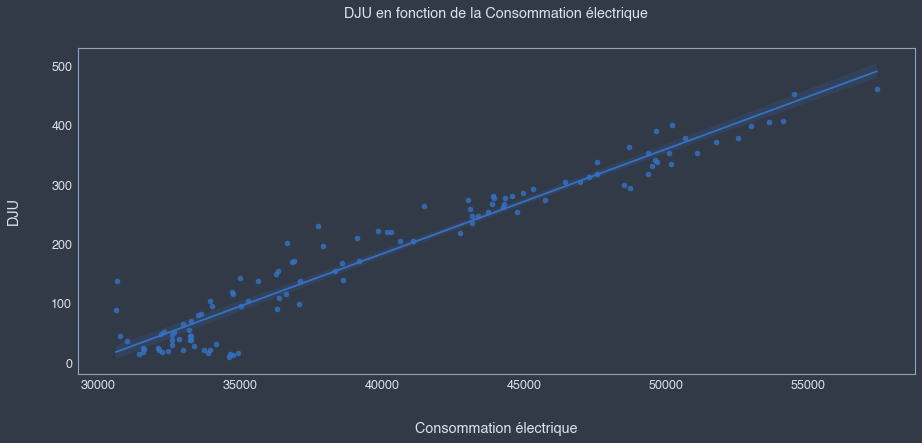

In [10]:
#dataviz
plt.figure(figsize=(15,6))

sns.regplot(x='Consommation totale', y='DJU', data=df)
plt.xlabel('Consommation électrique', labelpad=30)
plt.ylabel('DJU', labelpad=30)
plt.title("DJU en fonction de la Consommation électrique", pad=30)

plt.show()

In [11]:
#set explanatory and dependent variables
DJU = df['DJU']
consommation_totale = df['Consommation totale']

#linear regression
lr = smf.ols('consommation_totale ~ DJU', data=df).fit()
print(lr.summary())

#clean
del DJU, consommation_totale

                             OLS Regression Results                            
Dep. Variable:     consommation_totale   R-squared:                       0.934
Model:                             OLS   Adj. R-squared:                  0.934
Method:                  Least Squares   F-statistic:                     1577.
Date:                 Thu, 10 Feb 2022   Prob (F-statistic):           1.92e-67
Time:                         16:48:17   Log-Likelihood:                -1007.7
No. Observations:                  113   AIC:                             2019.
Df Residuals:                      111   BIC:                             2025.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.025e+04    296.497    102.02

<div class="admonition note alert alert-info" style="color:#4cb2ff">
Variance totale expliquée par le modèle : 93%
</div>

In [12]:
#new column for corrected consumption
df['Consommation totale corrigée'] = df['Consommation totale'] - (df['DJU'] * lr.params['DJU']).astype(int)

#### Analyse des résultats du modèle

##### Normalité des résidus

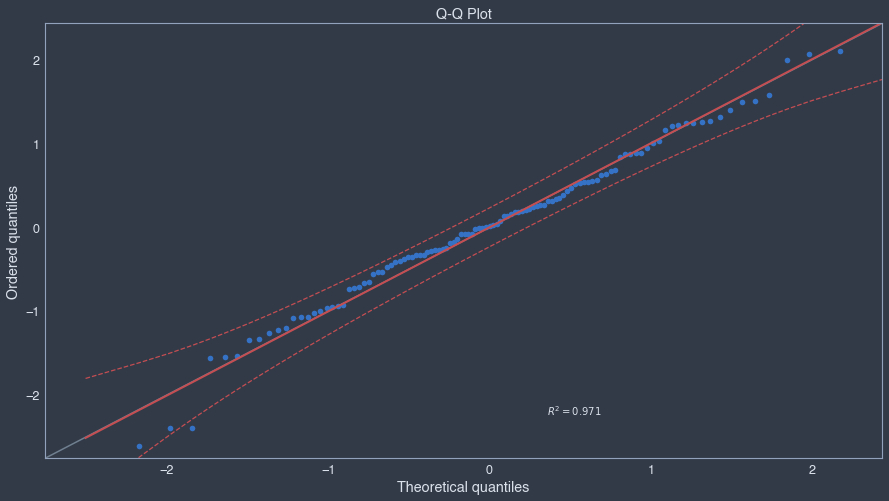

In [13]:
#dataviz
pg.qqplot(lr.resid, dist='norm', figsize=(15,8));

In [14]:
#D’Agostino and Pearson’s test
#more appropriate for large samples
pg.normality(lr.resid, method='normaltest')

,W,pval,normal
0,11.004443,0.004078,False


<div class="admonition note alert alert-info" style="color:#4cb2ff">
Bien que le test de D'Agostino Pearson nous amène à rejeter l'hypothèse de normalité, le fait que les résidus ne soient pas très différents d'une distribution symétrique (cf QQ-plot) et le fait que l'échantillon soit de taille suffisante (supérieur à 30), nous permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes.
</div>

##### Homoscedasticité des résidus

In [15]:
variables = lr.model.exog
_, pval, __, f_pval = het_breuschpagan(lr.resid, variables)

print("Breusch Pagan's test p-value :", pval)

#clean
del variables, _, pval, __, f_pval

Breusch Pagan's test p-value : 0.4646821656038834


<div class="admonition note alert alert-info" style="color:#4cb2ff">
La p-value étant supérieure à 5%, nous ne rejetons pas l'hypothèse H0 selon laquelle les variances sont constantes (l'hypothèse d'homoscédasticité).  
</div>

###  Datavisualisation

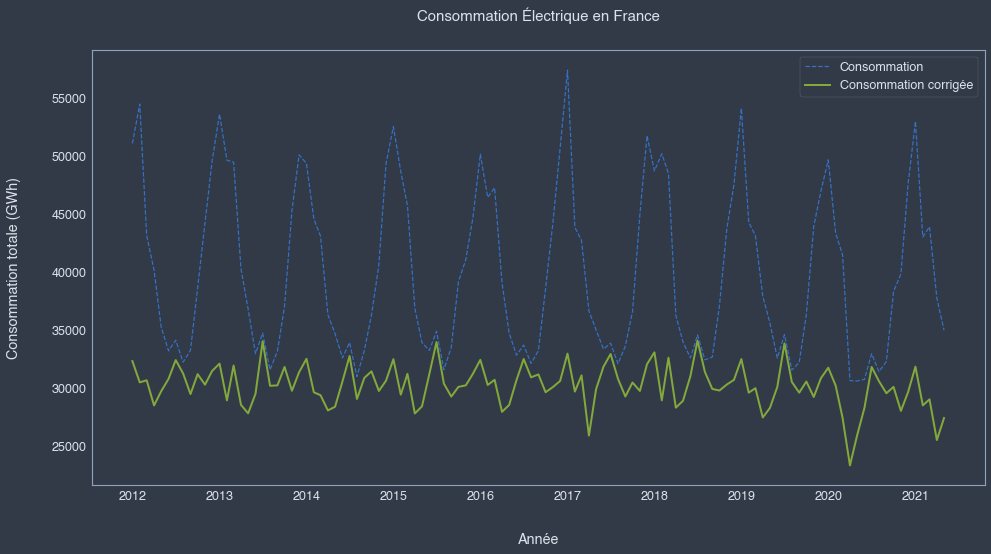

In [16]:
plt.figure(figsize=(16,8))

sns.lineplot(data=df, x='Mois', y='Consommation totale', linestyle='dashed')
sns.lineplot(data=df, x='Mois', y='Consommation totale corrigée', linewidth=2)

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation', 'Consommation corrigée'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)

plt.show()

## Mission 2 

Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

In [17]:
elec = df['Consommation totale corrigée']

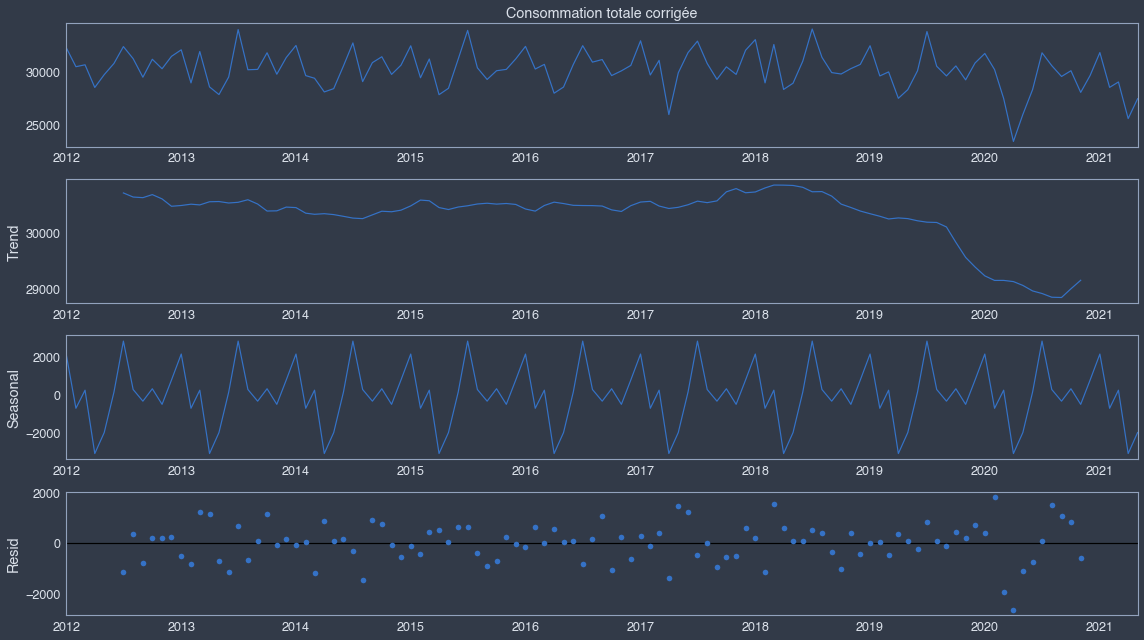

In [18]:
decomp = seasonal_decompose(elec, model='additif')

#dataviz
fig = decomp.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

plt.show()

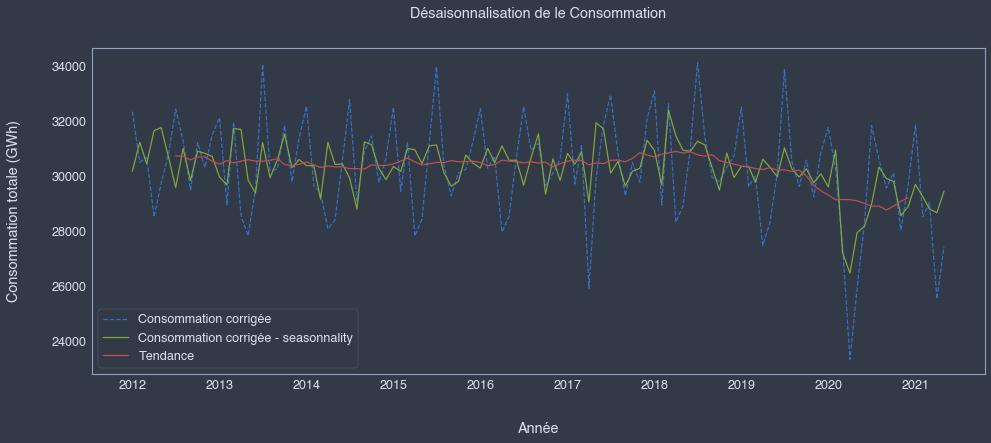

In [19]:
#subtract seasonal coefficients from the elec series
x_cvs = elec - decomp.seasonal

#period 12 seasonality
elec_ma = elec.rolling(window = 12, center = True).mean()

#dataviz
plt.figure(figsize=(16,6))

plt.plot(elec, label='Consommation corrigée', linestyle='dashed')
plt.plot(x_cvs, label='Consommation corrigée - seasonnality')
plt.plot(elec_ma, label='Tendance') 

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend()
plt.title('Désaisonnalisation de le Consommation', pad=30)

plt.show()

## Mission 3 

Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

### Méthode Holt-Winters

📌<br>
La méthode saisonnière Holt-Winters comprend l'équation de prévision et trois équations de lissage : une pour le niveau L, un pour la tendance T et un pour la composante saisonnière S, avec les paramètres de lissage correspondants à $\alpha$, $\beta$ & $\gamma$.

In [20]:
y = elec[:-12]
y_true = elec[-12:]

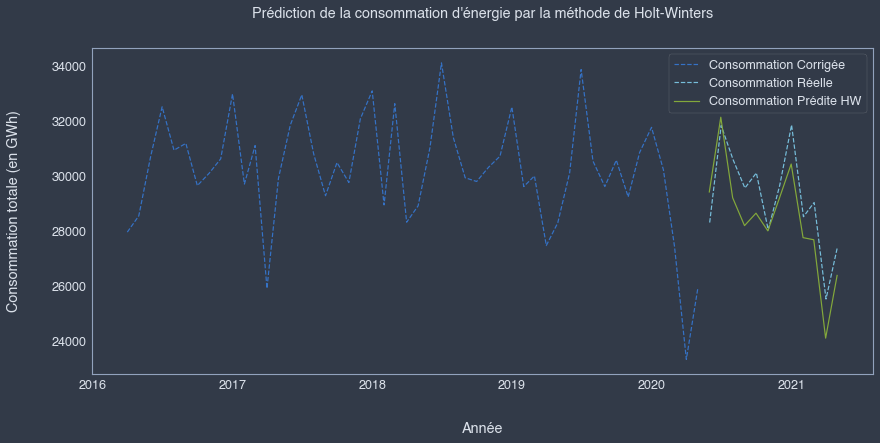

In [21]:
warnings.filterwarnings('ignore')

#Holt Winters
hw = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

#dataviz
plt.figure(figsize=(14,6))

plt.plot(y[-50:], label='Consommation Corrigée', linestyle='dashed')
plt.plot(y_true, label='Consommation Réelle', linestyle="dashed", color='c')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Consommation Prédite HW')
plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (en GWh)', labelpad=30)
plt.legend()

plt.title("Prédiction de la consommation d'énergie par la méthode de Holt-Winters", pad=30)
plt.show()

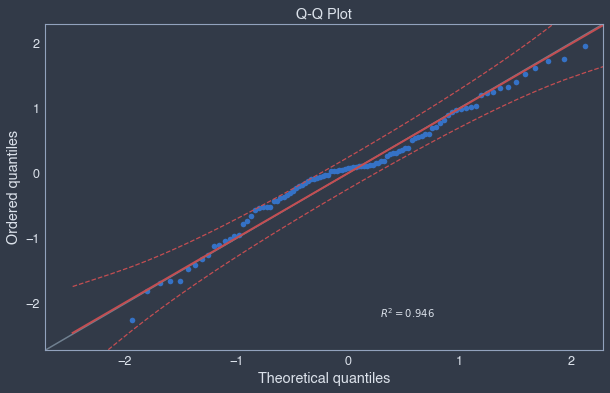

In [22]:
pg.qqplot(hw.resid, figsize=(10,6));

In [23]:
pg.normality(hw.resid, method='normaltest')

,W,pval,normal
0,19.149279,0.000069,False


In [24]:
#metrics
mse = mean_squared_error(y_true, hw_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - hw_pred) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  1117.07
MAPE =  3.47


### Méthode SARIMA

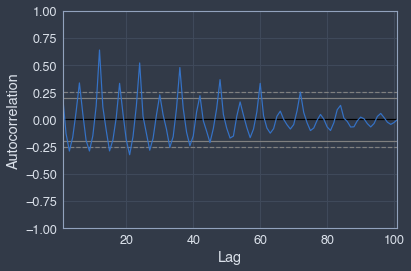

In [25]:
pd.plotting.autocorrelation_plot(y);

📚<br>
La plupart des séries temporelles présentent une tendance et/ou une saisonnalité, et ne sont donc pas modélisables par un processus stationnaire.

Afin de se ramener à un processus ARMA, il faut stationnariser la série et différentes méthodes sont envisageables (décomposition saisonnière, différenciation, Box-Cox et méthode empirique)

In [26]:
#Augmented Dickey-Fuller Test
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(y)
round(p_value,2)

0.97

<div class="admonition note alert alert-info" style="color:#4cb2ff">
La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité (confirmé par le test augmenté de Dickey-Fuller puisque la p-value est supérieur à 5%). On effectue donc une différenciation $(I−B)$.</div>

#### Stationnarisation

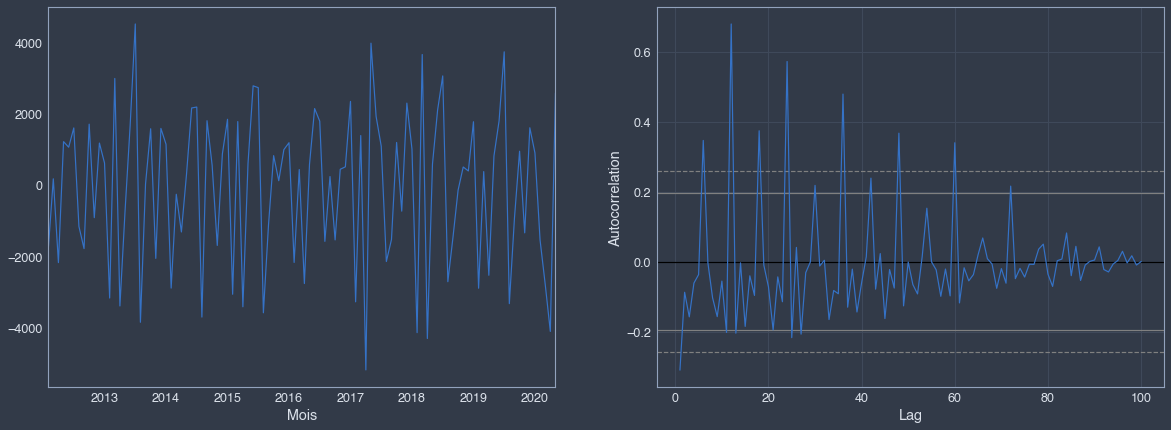

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7)) 

#Differentiation order 1
y_1 = y.diff().dropna() 

#Differentiated time series
y_1.plot(ax = ax1) 

#Autocorrelogram of the differentiated series
pd.plotting.autocorrelation_plot(y_1, ax=ax2); 

<div class="admonition note alert alert-info" style="color:#4cb2ff">
L'autocorrélation simple semble tendre vers 0 mais présente des pics saisonniers importants. Nous allons donc différencier la série temporelle de manière à éliminer la saisonnalité empêchant la stationnarité (pas encore de décroissance rapide vers zéro). On effectue cette fois une différenciation $(I−B^{12})$.</div>

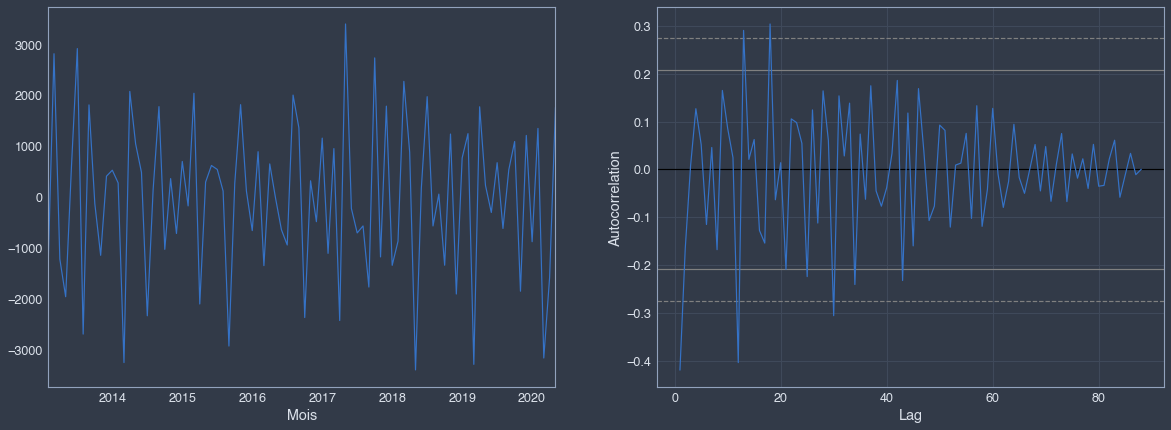

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

#Differentiation order 12
y_2 = y_1.diff(periods=12).dropna()

#Double differentiated series
y_2.plot(ax = ax1) 

#Autocorrelogram
pd.plotting.autocorrelation_plot(y_2, ax=ax2); 

<div class="admonition note alert alert-info" style="color:#4cb2ff">
On arrive ici à un résultat assez satisfaisant malgré les quelques pics irréguliers. On peut dire que les valeurs décroissent suffisamment rapidement pour qu'on puisse considérer le processus comme probablement stationnaire.</div>

In [29]:
#Augmented Dickey-Fuller Test
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(y_2)
round(p_value,2)

0.03

<div class="admonition note alert alert-info" style="color:#4cb2ff">
La p-value étant inférieure à 5%, la série est donc probablement stationnaire.  
</div>

#### Identification du modèle à priori

📚<br>
Un modèle SARIMA s'écrit sous la forme SARIMA(p,d,q)(P,D,Q)k. Les termes d et D correspondent aux degrés de différenciation utilisés pour stationnariser la série temporelle. La seconde parenthèse contenant les termes en majuscule correspond à la partie saisonnière de la SARIMA et k indique la saisonnalité utilisée.
<br><br>
Ainsi le processus SARIMA combine à la fois une différenciation simple et saisonnière avec un processus ARMA simple
et un processus ARMA selon la saisonnalité.

<div class="admonition note alert alert-info" style="color:#4cb2ff">
On a donc identifié une saisonnalité de période 12 (k=12). De plus nous avons fait une différenciation simple (d=1) et une différenciation saisonnière (D=1) pour stationnariser notre série temporelle.
<br><br>  
Ainsi notre modèle sera de la forme SARIMA(p,1,q)(P,1,Q)12. Il convient alors de choisir les bons ordres p, q, P et Q pour nos processus ARMA.
<br><br> 
Pour déterminer les ordres d'un processus AR ou MA, il est possible de s'appuyer à nouveau sur les diagrammes d'autocorrélation ou autocorrélogrammes.
</div>

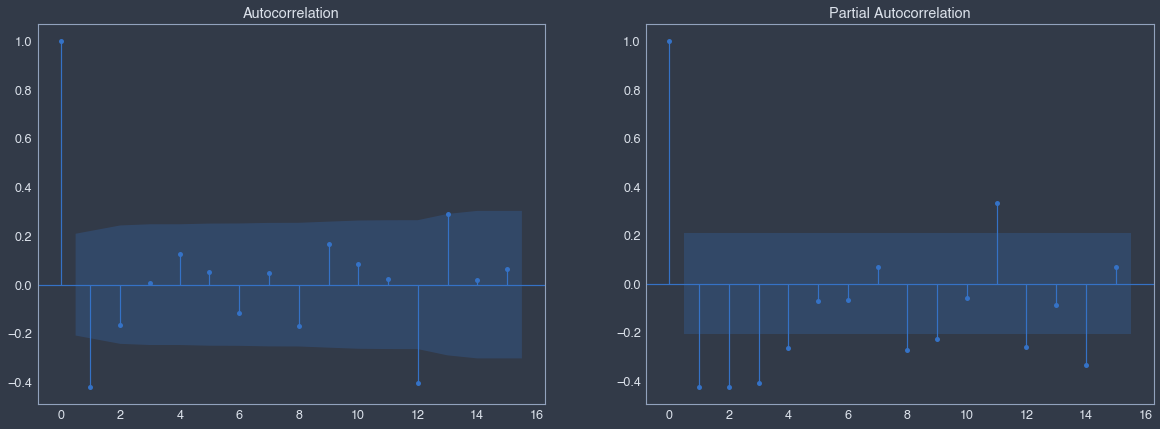

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(y_2, lags=15, ax=ax1)
plot_pacf(y_2, lags=15, ax=ax2)
plt.show()

In [31]:
model = SARIMAX(y, order=(1,1,1), seasonal_order=(0,1,1,12))
sarima = model.fit(disp=False)
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:       Consommation totale corrigée   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -764.128
Date:                            Thu, 10 Feb 2022   AIC                           1536.256
Time:                                    16:48:20   BIC                           1546.166
Sample:                                01-01-2012   HQIC                          1540.248
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3137      0.228      1.373      0.170      -0.134       0.761
ma.L1         -0.4871      0.228   

#### Vérification des modèles potentiels

<div class="admonition note alert alert-info" style="color:#4cb2ff">
Comme le premier paramètre AR d'ordre 1 à une p-valeur supérieure à 5%, on peut donc considérer ce paramètre comme non significatif et le supprimer du modèle pour le simplifier. </div>

In [32]:
model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,12))
sarima = model.fit(disp=False)
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:       Consommation totale corrigée   No. Observations:                  101
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -764.969
Date:                            Thu, 10 Feb 2022   AIC                           1535.938
Time:                                    16:48:20   BIC                           1543.370
Sample:                                01-01-2012   HQIC                          1538.932
                                     - 05-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1741      0.027     -6.449      0.000      -0.227      -0.121
ma.S.L12      -0.2232      0.046   

<div class="admonition note alert alert-info" style="color:#4cb2ff">
Le test de Ljung-Box est un test de blancheur des résidus. C'est un test statistique qui vise à rejeter ou non 
l'hypothèse H0 : blancheur des résidus.
<br><br>
Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0 : les résidus suit une distribution normale. D'après la documentation officielle de scipy ce test ne fonctionne que pour un nombre suffisant d'échantillons de données (>2000).</div>

In [33]:
acorr_ljungbox(sarima.resid, lags=[6, 12, 18, 24, 40, 36], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,1.128274,0.980279,1.063995,0.983070
12,19.571724,0.075634,17.047335,0.147825
18,22.738038,0.200858,19.659078,0.352337
24,23.717336,0.477853,20.403996,0.673585
40,26.875398,0.944204,22.540244,0.988209
36,26.415050,0.878693,22.261378,0.964596


<div class="admonition note alert alert-info" style="color:#4cb2ff">
Les tests de significativité des paramètres et de blancheur des résidus sont donc validés au niveau 5%.
</div>

In [34]:
#normality of residuals
pg.normality(sarima.resid, method='normaltest')

,W,pval,normal
0,127.957511,1.638248e-28,False


<div class="admonition note alert alert-info" style="color:#4cb2ff">
Le test de normalité est donc rejeter pour ce modèle.
</div>    

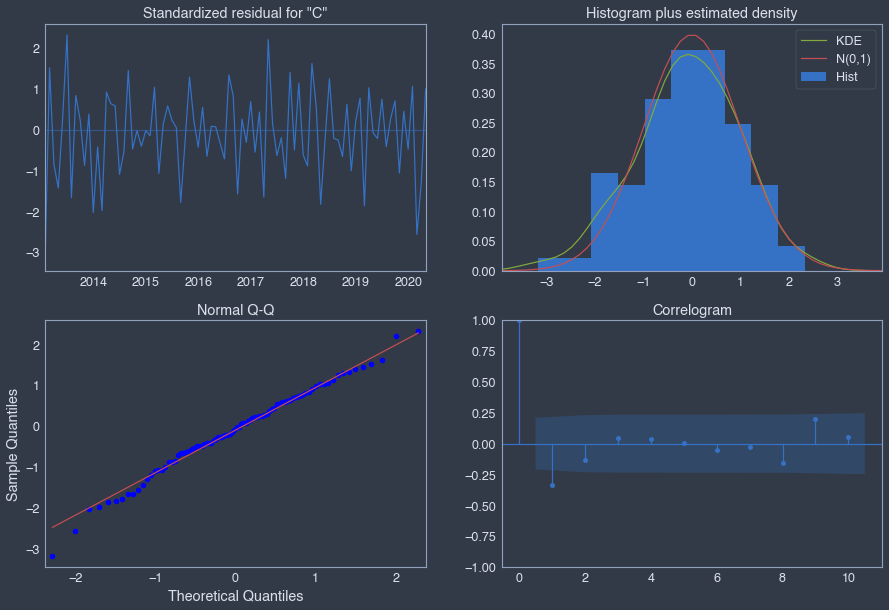

In [35]:
sarima.plot_diagnostics(figsize=(15,10));

📌<br>

| Test                            | Good Fit | 
| :------------------------------ |:--------------- |
| Résidus standardisé             | Il n'y a pas de modèles évidents dans les résidus | 
| Histogramme plus estimation kde | La courbe KDE devrait être très similaire à la distribution normale |
| Q-Q normal                      | La plupart des points de données devraient se trouver sur la ligne droite | 
| Corrélogramme                   | 95 % des corrélations pour un décalage supérieur à zéro ne devraient pas être significatives | 

#### Prévision

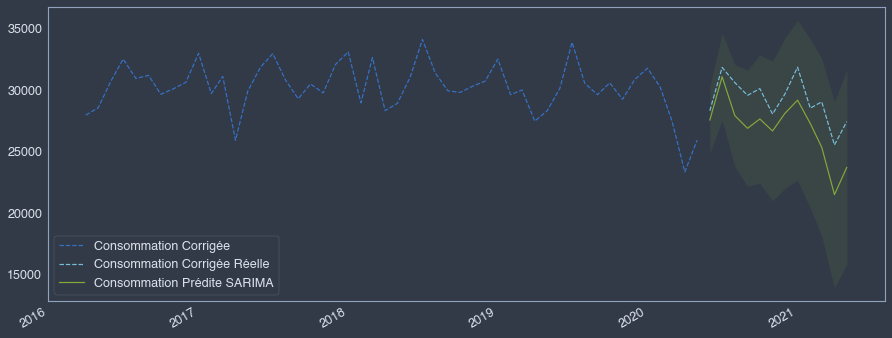

In [36]:
#prediction with confidence interval
prediction = sarima.get_forecast(steps=12).summary_frame()  

fig, ax = plt.subplots(figsize = (15,6))

plt.plot(y[-50:], linestyle='--', label='Consommation Corrigée')
plt.plot(y_true,linestyle='--', label='Consommation Corrigée Réelle', color='c')
prediction['mean'].plot(ax=ax, color='g', label='Consommation Prédite SARIMA') 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)

plt.legend();

In [37]:
#metrics
mse = mean_squared_error(y_true, prediction['mean'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - prediction['mean']) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  2554.37
MAPE =  8.0


#### Choix définitif du modèle

<div class="admonition note alert alert-info" style="color:#4cb2ff">
L'utilisation des autocorrélogrammes pour déterminer les ordres de la  SARIMA n'est pas une règle forte. L'interprétation n'en pas toujours aisée et univoque. Ainsi il faut voir cette méthode comme une aide pour le choix de ces paramètres mais qui devra ensuite être confirmée via l'étude de leur significativité et la vérification de la 
blancheur des résidus.
<br><br>
Il peut arriver que plusieurs modèles différents soient pertinents lorsque toutes les hypothèses sont validées. Dans
ce cas pour choisir quel modèle conserver, on pourra s'appuyer sur les critères d'information AIC, BIC et HQIC indiqués dans la première partie des résultats de la  SARIMA.
<br><br>
Le critères d'information sont des mesures statistiques permettant de quantifier la performance d'un modèle tout en 
prenant en compte sa parcimonie. Ainsi un bon critère d'information indique un modèle performant avec peu de paramètres. On sélectionnera donc le modèle avec les critères d'information les plus faibles.</div>

#### Auto Arima

In [38]:
s_model = auto_arima(y,
                     test='adf',
                     max_p=2, 
                     max_q=2,
                     m=12,
                     max_P=2,
                     max_Q=2,
                     seasonal=True,
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True,
                     n_jobs=-1,
                     information_criterion='aic')

s_results = s_model.fit(y)

s_resid = pd.Series(s_results.resid(), index=y.index)

print(s_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1544.570, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1539.315, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1535.938, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1541.336, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1534.380, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1537.679, Time=0.12 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1534.142, Time=0.25 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1535.866, Time=0.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1534.474, Time=0.52 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1534.368, Time=0.39 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1535.489, Time=0.11 sec
 ARIMA(1,1,2)(0,1,2)[12]          

In [39]:
acorr_ljungbox(s_resid, lags=[6, 12, 18, 24, 40, 36], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,1.059935,0.983238,1.000066,0.985610
12,20.045571,0.066229,17.449871,0.133444
18,23.161419,0.184463,20.020477,0.331668
24,23.671696,0.480494,20.417095,0.672827
40,26.856829,0.944509,22.555702,0.988130
36,26.237760,0.883811,22.180788,0.965611


In [40]:
#normality of residuals
pg.normality(s_resid, method='normaltest')

,W,pval,normal
0,130.775883,4.002927e-29,False


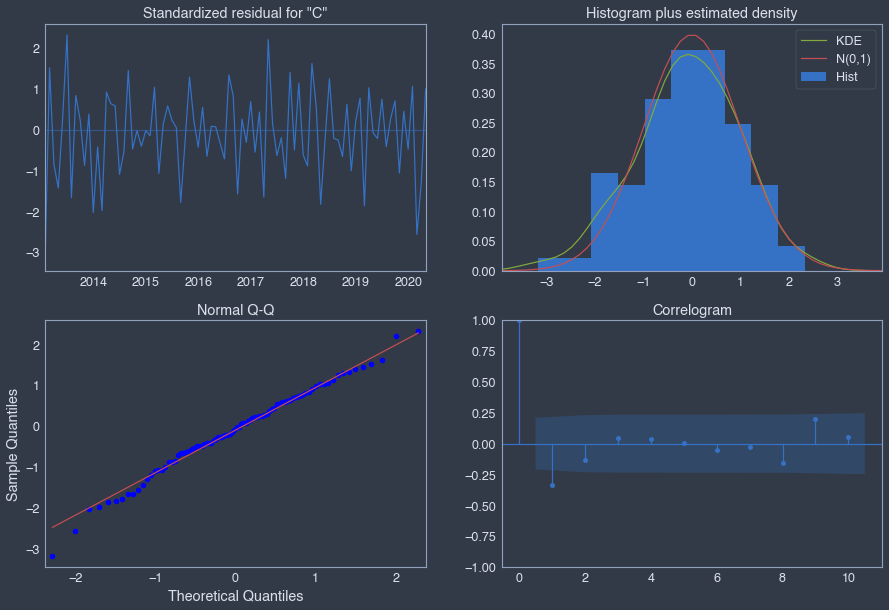

In [41]:
sarima.plot_diagnostics(figsize=(15,10));

In [42]:
model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,2,12))
sarima = model.fit(disp=False)
print(sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:            Consommation totale corrigée   No. Observations:                  101
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -763.071
Date:                                 Thu, 10 Feb 2022   AIC                           1534.142
Time:                                         16:48:26   BIC                           1544.051
Sample:                                     01-01-2012   HQIC                          1538.134
                                          - 05-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1604      0.028     -5.695      0.000      -0.216      -0

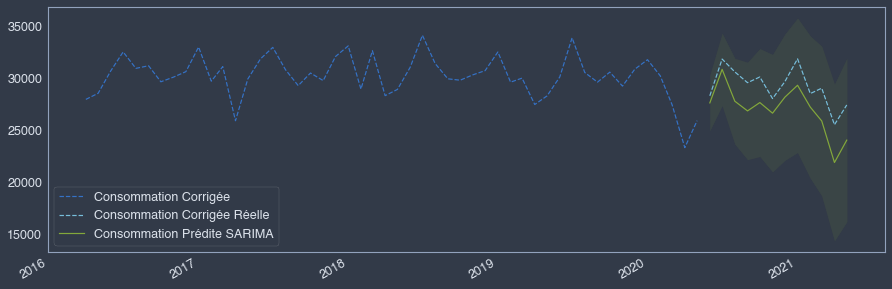

In [43]:
prediction = sarima.get_forecast(steps=12).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(y[-50:], linestyle='--', label='Consommation Corrigée')
plt.plot(y_true,linestyle='--', label='Consommation Corrigée Réelle', color='c')
prediction['mean'].plot(ax=ax, color ='g', label='Consommation Prédite SARIMA') 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)
         
plt.legend();

In [44]:
#metrics
mse = mean_squared_error(y_true, prediction['mean'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - prediction['mean']) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  2401.6
MAPE =  7.64


## Comparaison des deux modèles

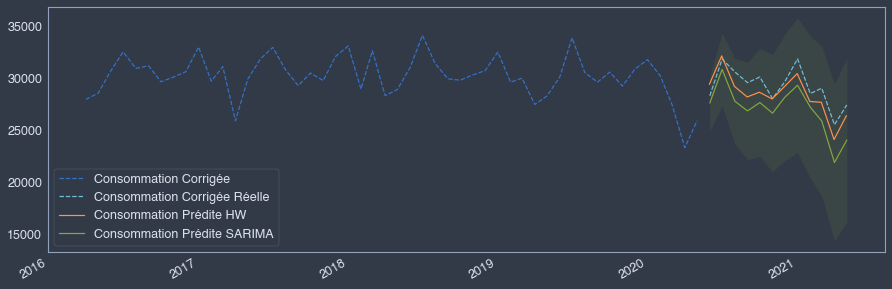

In [45]:
prediction = sarima.get_forecast(steps=12).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(y[-50:], linestyle='--', label='Consommation Corrigée')
plt.plot(y_true,linestyle='--', label='Consommation Corrigée Réelle', color='c')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Consommation Prédite HW', color='y')
prediction['mean'].plot(ax=ax, color='g', label='Consommation Prédite SARIMA') 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)
         
plt.legend();

## Bonus : Grid Search

📌<br>
[Source](https://ichi.pro/fr/recherche-de-grille-pour-les-parametres-sarimax-191028619692939)

In [46]:
### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets 
# Note: here we have 12 in the 's' position as we have monthly data
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

# Run Grid Search with pdq and seasonal pdq parameters and get the best AIC / BIC value #
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):                                               
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(ts, # this is your time series you will input
                              order=comb,
                              seasonal_order=combs,
                              enforce_stationarity=False,
                              enforce_invertibility=False,
                              )

                output = mod.fit(maxiter=maxiter, disp=False) 
                ans.append([comb, combs, output.aic, output.bic])
                #print('SARIMAX {} x {}12 : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, output.aic, 
                #output.bic))
            except:
                continue
                                                
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])

    # Sort and return top 10 combinations
    ans_df = ans_df.sort_values(by=['aic', 'bic'], ascending=True)[0:10]
    
    return ans_df

In [47]:
sarimax_gridsearch(y, pdq, pdqs, maxiter=50)

,pdq,pdqs,aic,bic
449,"(1, 2, 1)","(1, 2, 2, 12)",12.000000,23.350922
305,"(1, 0, 2)","(0, 2, 2, 12)",12.000000,23.472138
611,"(2, 1, 1)","(1, 2, 2, 12)",14.000000,27.384161
311,"(1, 0, 2)","(1, 1, 2, 12)",14.000000,28.889941
554,"(2, 0, 2)","(1, 1, 2, 12)",16.000000,33.017075
473,"(1, 2, 2)","(1, 1, 2, 12)",91.060315,105.720727
437,"(1, 2, 1)","(0, 1, 2, 12)",328.470961,339.025330
455,"(1, 2, 1)","(2, 1, 2, 12)",503.015745,517.791862
161,"(0, 1, 2)","(2, 2, 2, 12)",852.780752,866.023494
404,"(1, 1, 2)","(2, 2, 2, 12)",854.116060,869.250622


<div class="admonition note alert alert-info" style="color:#4cb2ff">
Malheureusement, aucun de ces modèles ne satisfait les différentes vérifications nécessaires à la validité du modèle. Il serait intéréssant d'approfondir cette démarche en ajoutant des conditions sur ces vérifications justement. De plus, dans le cours proposé par OpenClassRooms, il est suggéré de se trouner vers les modèles GARCH ou ARCH 

📌<br>
Modèle GARCH ou ARCH si non respect de la normalité ? 